In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
# Load the dataset
df = pd.read_csv("Customer-Churn-Records.csv")

# 1. Feature Selection: Drop irrelevant identification columns
df_clean = df.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

# Identify the target variable
target_variable = 'Exited'

# Identify categorical columns to encode
categorical_cols = ['Geography', 'Gender', 'Card Type']

# 2. Categorical Encoding: One-Hot Encode the categorical variables
df_encoded = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)

print("--- Cleaned and Encoded Data Head ---")
print(df_encoded.head().to_markdown(index=False, numalign="left", stralign="left"))
print("\nShape of the processed data:", df_encoded.shape)

--- Cleaned and Encoded Data Head ---
| CreditScore   | Age   | Tenure   | Balance   | NumOfProducts   | HasCrCard   | IsActiveMember   | EstimatedSalary   | Exited   | Complain   | Satisfaction Score   | Point Earned   | Geography_Germany   | Geography_Spain   | Gender_Male   | Card Type_GOLD   | Card Type_PLATINUM   | Card Type_SILVER   |
|:--------------|:------|:---------|:----------|:----------------|:------------|:-----------------|:------------------|:---------|:-----------|:---------------------|:---------------|:--------------------|:------------------|:--------------|:-----------------|:---------------------|:-------------------|
| 619           | 42    | 2        | 0         | 1               | 1           | 1                | 101349            | 1        | 1          | 2                    | 464            | False               | False             | False         | False            | False                | False              |
| 608           | 41    | 1        | 83807.9   

In [5]:
# Separate features (X) and target (y)
X = df_encoded.drop(target_variable, axis=1)
y = df_encoded[target_variable]

# Identify numerical features for scaling
# Select all columns that are not the target or the encoded categorical features
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()

# 3. Data Split: Split into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 4. Feature Scaling: Initialize and fit StandardScaler on the training data
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

print("\n--- Training Data Head after Scaling ---")
print(X_train.head().to_markdown(index=False, numalign="left", stralign="left"))
print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")


--- Training Data Head after Scaling ---
| CreditScore   | Age        | Tenure      | Balance   | NumOfProducts   | HasCrCard   | IsActiveMember   | EstimatedSalary   | Complain   | Satisfaction Score   | Point Earned   | Geography_Germany   | Geography_Spain   | Gender_Male   | Card Type_GOLD   | Card Type_PLATINUM   | Card Type_SILVER   |
|:--------------|:-----------|:------------|:----------|:----------------|:------------|:-----------------|:------------------|:-----------|:---------------------|:---------------|:--------------------|:------------------|:--------------|:-----------------|:---------------------|:-------------------|
| 1.62641       | -1.32016   | 0.69136     | -1.23003  | 0.804113        | -1.55445    | 0.961319         | -1.328            | -0.507356  | 0.699295             | -0.978106      | False               | True              | True          | True             | False                | False              |
| -0.928773     | 1.61449    | 0.69136     | 1.22115

In [7]:
# 5. Model Building: Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# 6. Training: Train the model on the scaled training data
print("\n--- Starting Model Training ---")
rf_model.fit(X_train, y_train)
print("--- Model Training Complete ---")


--- Starting Model Training ---
--- Model Training Complete ---



      Model Performance on Test Data

--- Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2389
           1       1.00      1.00      1.00       611

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000

ROC AUC Score: 0.9984
Confusion Matrix plot saved as 'confusion_matrix.png'
Feature Importance plot saved as 'feature_importance.png'


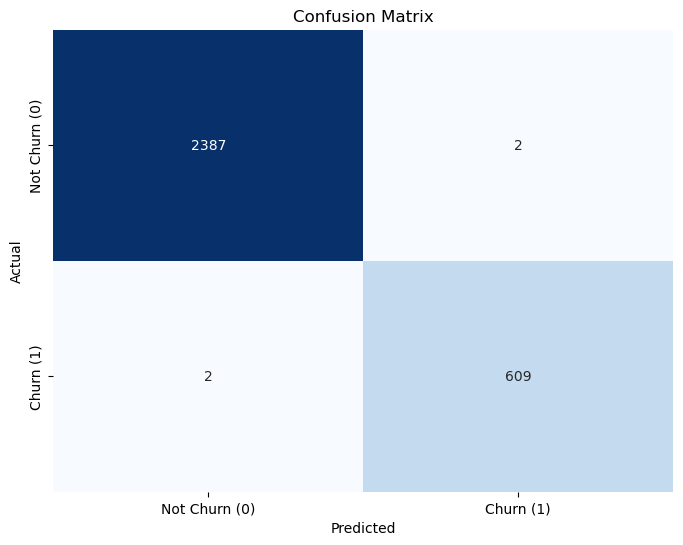

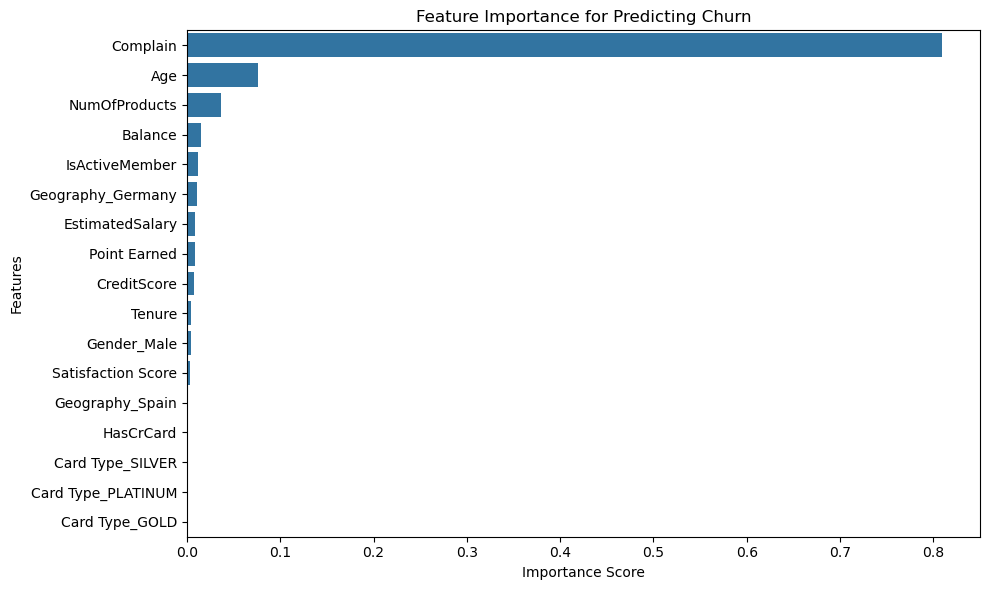

In [9]:
# 7. Prediction: Make predictions and probability estimates on the test set
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1] # Probability of class 1 (Exited)

# 8. Evaluation: Calculate and print performance metrics
print("\n==============================================")
print("      Model Performance on Test Data")
print("==============================================")

# Classification Report
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Churn (0)', 'Churn (1)'],
            yticklabels=['Not Churn (0)', 'Churn (1)'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('confusion_matrix.png')
print("Confusion Matrix plot saved as 'confusion_matrix.png'")

# Feature Importance
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title('Feature Importance for Predicting Churn')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig('feature_importance.png')
print("Feature Importance plot saved as 'feature_importance.png'")